# Glioma Grading Classification based on Clinical and Genetic Features

This notebook aims at properly classifying the two different grades of CNS glial cells cancer: low-grade gliomas (LGG) and high-grade gliomas (HGG). While the former is slowly progressing and usually does not require treatment, the latter is incredibly aggressive and frequently metastatizes. Thus, correct classification is pivotal to ensure each patient receives adequate care for their specific glioma type.

The employed dataset is taken from the TCGA (the Cancer Genome Atlas) Program, which provides the 20 most frequently mutated genes in glioma patients, as well as several clinical features. 

In what follows, we will carry out:
- Exploratory data analysis and data preprocessing;
- Categorical dimensionality reduction;
- Model selection out of a range of possible classifiers; 
- Improve the classifiers' performance through hyperparameter tuning.

In [ ]:
# TODO 0: Create venv and install necessary packages.

In [ ]:
# TODO 1: import necessary packages


In [ ]:
# TODO 2: import LogisticRegression from sklearn


In [75]:
# necessary import statements
import warnings
warnings.filterwarnings('ignore')
from collections import OrderedDict
from operator import itemgetter


import plotly.graph_objs as go
from plotly.subplots import make_subplots

from sklearn import tree 
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV , cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, roc_curve, auc, recall_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

First, let us visualize the raw dataset. 

Immediately, we notice that the only type of High Grade Glioma is Glioblastoma Multiforme (GBMs), which is considered a grade IV astrocytoma. Further, the dataset does not distinguish between primary GBMs (arising de novo) and secondary GBMs (evolving from lower grades); thus, drawing molecular conclusions on the differences between the two will not be straightforward. Interestingly, this dataset classifies grade III gliomas as low-grade, which is in conflict with World Health Organization glioma grade classifications.

In [ ]:
# TODO 3: import data from csv and display it


## Data preprocessing

Below, we identify unique values and remove non-reported values. Further:
    
- We assign:
  - A value of 1 to mutated genes;
  - A value of 0 to non-mutated genes;
  - A value of 1 to the very aggressive Glioblastoma Multiforme ('GBM');
  - A value of 0 to the milder Low-grade Gliomas ('LGG');
  - A value of 1 for females;
  - A value of 0 for males.

- We one-hot encode the race feature. Please note that this was the only one-hot encoded feature, whereas every gene was simply given a value of 0 or 1. This was done in an effort to not excessively increase dimensionality.

- We turn all non numerical values in the 'Age_at_diagnosis' column into numerical values. For example, '51 years 108 days'	becomes 51.295890. As the age boxplot does not show outliers, we can impute the missing age values with the mean value (rather than the median). Finally, we normalize age values. 

In [ ]:
# TODO 4: what should we do with the 'Case_ID', 'Project,' and 'Primary_Diagnosis' columns? How necessary are they for this problem?


In [ ]:
for i in df.columns:
    print(f'for column {i} unique values are: {df[i].unique()}')

In [ ]:
# TODO 5: Replace categorical variables with binary values to feed to the models


In [ ]:
# Removing rows with not identified variables
df = df[ (df['Gender'] != '--') & (df['Race'] != 'not reported')]

In [ ]:
# TODO 6: Drop unnecessary columns


In [ ]:
# One hot encoding for race column


In [ ]:
# Converting column 'Age_at_diagnosis' to numerical data
years = df['Age_at_diagnosis'].str.split(' ', expand=True)
years.drop(columns=[1, 3], inplace=True) # Dropping unnecessary columns (with words years and days)
years[0] = pd.to_numeric(years[0], errors='coerce') # Converting years to numerical data
years[2] = pd.to_numeric(years[2], errors='coerce') # Converting days to numerical data
years[0] = years[0] + years[2] / 365 # Corrected this line
df['Age_at_diagnosis'] = years[0]
df

In [ ]:
# Imputing missing age values with mean and not median, as the boxplot shows no outliers
df.rename(columns={'Age_at_diagnosis': 'Age'}, inplace=True)
df['Age'].fillna(df['Age'].mean(), inplace=True)
# visualizing statistics of the data
df.describe()

In [ ]:
# TODO 7: Plot distribution of age to see if there are any outliers


In [ ]:
# Normalizing age
df['Age'] = (df['Age'] - df['Age'].mean()) / df['Age'].std()
df

In [ ]:
# Descriptive statistics
df.describe()

# Data visualization 

### Clinical Features

Below, we visualize data and inspect: 
- How gender distributes by age for the current dataset;
- The prevalence of gliomas by gender.

Notably, there are more men in the dataset than women, but age is relatively similarly distributed across genders.

In [ ]:
# Checking age distribution by gender
plt.figure(figsize=(10, 5))
sns.histplot(x='Age', data=df, hue='Gender', palette={0: 'blue', 1: 'pink'}, hue_order=[0, 1], multiple='stack', bins=20, kde=True)
plt.title('Age Distribution by gender')
plt.legend(title='Gender', labels=['Women', 'Men'])
plt.show()

# Counting the number of each gender in the dataset
df['Gender'].value_counts()

Notably, the cell below shows that our data is in full accordance with current glioma literature. Specifically: 
- Men are more affected than women; 
- This gender imbalance is more prominent for high-grades gliomas. As a reminder, high-grade GBMs is given a value of 1, whereas the LGGs are given a value of 0.

In [ ]:
# TODO 8: Plot distribution of glioma by gender, color coding data based on gender


### Genetic Features

Now, we index the dataset to only visualize the 20 genetic features, specifically: 
- their mutation frequence; 
- the mutation distribution for each gene.

Both tables point to mutations on the IDH1 gene being extremely common. This is not surprising, as this gene is termed the “trunk” (or initiating) event in the genesis of IDH-mutant gliomas.

The other mutation patterns (such as the prevalent mutations on TPRX and ATRX genes) are coherent with the latest literature on glial cells tumorogenesis, despite the dataset not providing information as to whether a GBM is primary or secondary.

In [ ]:
# Distribution of most commonly mutated genes in the dataset 
df['Most_commonly_mutated_gene'] = df.iloc[:, 3:-5].idxmax(axis=1)
plt.figure(figsize=(10, 5))

sns.countplot(data=df, y='Most_commonly_mutated_gene', palette='Set2')
plt.xlabel('Count')
plt.ylabel('Gene')
plt.title('Distribution of most commonly mutated genes')
plt.show()

In [ ]:
#mutation distribution for each gene
fig = make_subplots(rows=5, cols=4)

# Loop through columns 3 to 22 (indexing from 0 to 19)
column_names = []  # List to store column names for legend

for i, column in enumerate(df.iloc[:, 3:23].columns, start=1):
    row_num = (i - 1) // 4 + 1  # Calculate row number
    col_num = (i - 1) % 4 + 1   # Calculate column number

    value_counts = df[column].value_counts()

    # Map the index to the desired labels
    x_labels = value_counts.index.map({0: 'Non-mutated', 1: 'Mutated'})

    fig.add_trace(
        go.Bar(x=x_labels, y=value_counts.values),
        row=row_num, col=col_num
    )
    
    column_names.append(f'Column {column}')  # Store column names for legend

    fig.update_xaxes(title_text=f'{column}', row=row_num, col=col_num)  

# Update layout for all subplots
fig.update_layout(title='Mutation Distribution for Each of the 20 Most Commonly Mutated Genes', width = 1000, height = 1200)
fig.for_each_trace(lambda trace: trace.update(name=column_names.pop(0)))  # Update trace names using stored column names
fig.show()

### Conclusions of the Exploratory Data Analysis 

Thorough comparison of the dataset with the existing literature on gliomas was necessary in order to fully comprehend the task at hand.
It appears that genetic and clinical information in the dataset aligns with what is currently known about LGGs and HGGs. Some variation is present, but we conclude that this may be due to statistical noise, sampling variability or the nature of TCGA. In fact: 
- the dataset only classifies GBMs as HGGs, which is no longer in accordance with the WHO guidelines;
- the dataset does not distinguish between GBM subtypes. 

Although the EDA proved insightful, these factors should caution against drawing definitive conclusions from these findings.


## Model Selection

A variety of binary classification models will be trained, namely: Logistic Regression, DecisionTrees, Random Forest and AdaBoost.

In [ ]:
# Remove column 'most commonly mutated genes' from dataframe before fitting model, otherwise string error
df = df.iloc[:, :-16]

In [ ]:
# TODO 9: Define label and features


In [ ]:
# TODO 10: Split data into train and test sets, 70% train, 30% test



In [ ]:
# TODO 11: Create a list of potential models: 


[1 1 1 0 1 1 1 1 0 1 1 0 1 0 1 0 1 1 1 0 0 1 1 0 0 0 1 1 0 0 1 0 0 0 0 1 1
 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 0 1 1
 0 1 1 1 1 0 1 1 1 0 0 0 1 0 1 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0
 0 0 1 0 1 0 0 0 1 1 0 1 1 0 1 1 1 0 0 1 1 1 0 1 0 0 0 1 0 1 0 1 0 0 1 0 1
 0 1 0 1 0 1 0 1 1 0 0 0 1 0 1 1 0 0 0 1 1 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1
 0 0 0 1 0 0 0 0 1 0 1 0 1 0 0 1 0 1 1 0 1 0 1 1 0 0 0 0 1 0 0 1 1 1 0 0 0
 0 0 0 0 1 1 1 1 0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 1 1 0 0 0]
0.8690476190476191 0.9239130434782609


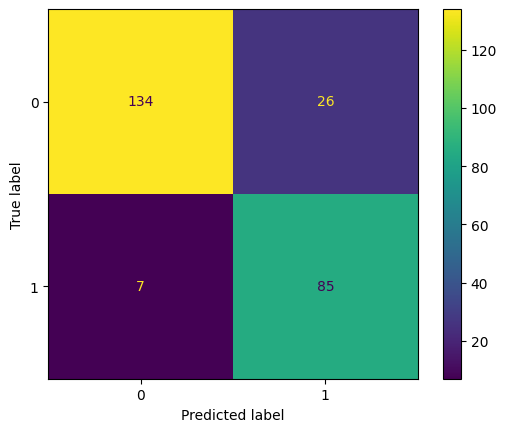

In [ ]:
# TODO 12: Train and evaluate the logistic regression model first
# TODO 12a: Train the logistic regression model


# TODO 12b: Evaluate on the test set

# STEP 1: Get model predictions and store in variable 'y_pred'. Print y_pred to check.
#y_pred=
#print(y_pred)

# STEP 2: Evaluate model based on accuracy and recall. Print accuracy and recall to check.
#accuracy=
#recall=
#print(accuracy, recall)

# STEP 3: Organize results in a confusion matrix, and analyze the results. Simply uncomment the lines below.
# cm = confusion_matrix(y_test, y_pred, labels = model1.classes_)
# disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = model1.classes_)
# disp.plot()
# plt.show()



LogisticRegression()
Accuracy of LogisticRegression() is 0.8690476190476191
Recall (sensitivity) of LogisticRegression() is 0.9239130434782609


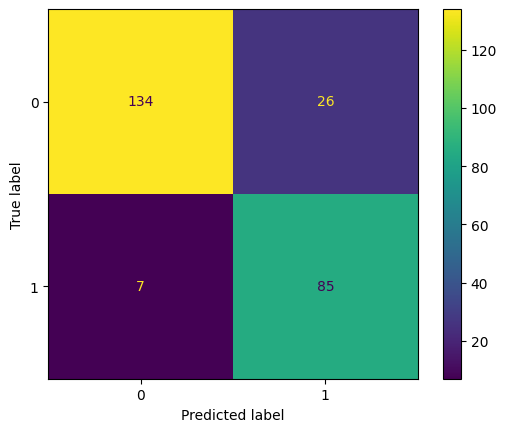

-------------------------------------------------------
DecisionTreeClassifier()
Accuracy of DecisionTreeClassifier() is 0.8174603174603174
Recall (sensitivity) of DecisionTreeClassifier() is 0.8152173913043478


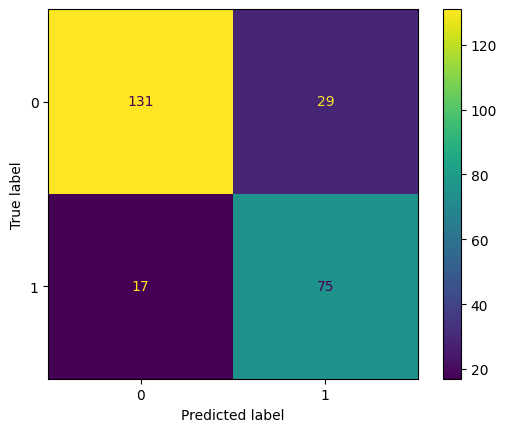

-------------------------------------------------------
RandomForestClassifier()
Accuracy of RandomForestClassifier() is 0.8333333333333334
Recall (sensitivity) of RandomForestClassifier() is 0.8152173913043478


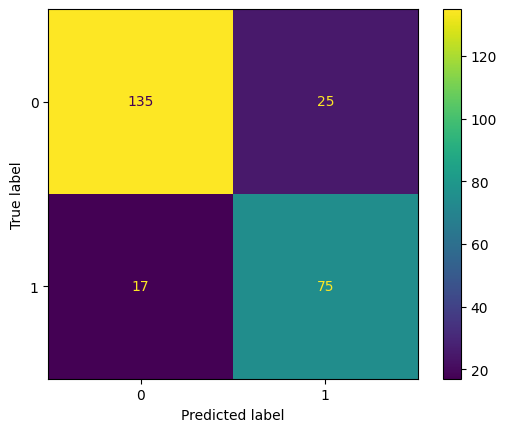

-------------------------------------------------------
AdaBoostClassifier()
Accuracy of AdaBoostClassifier() is 0.8611111111111112
Recall (sensitivity) of AdaBoostClassifier() is 0.9347826086956522


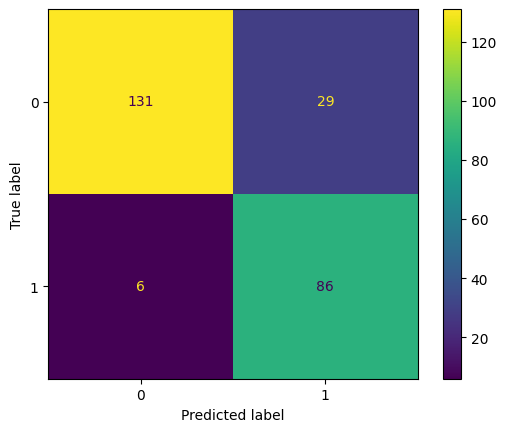

-------------------------------------------------------


In [ ]:
# TODO 13: 
##### For each of the models, run the entire training and evaluation pipeline. Store accuracy and recall of models in a dictionary.

# Step 1: Create dict for storing model's accuracy 

# Step 2: Loop through each of the models
for model in models:
    # Step 2a: Fit the model. 

    # Step 2b: Fetch model predictions and store in y_pred.

    # Step 2c: Calculate and print accuracy and recall, respectively.

    print(f"Accuracy of {model} is {accuracy}")
    print(f'Recall (sensitivity) of {model} is {recall}')

    # Step 2d: Store the accuracy of the model in the dictionary accordingly.


    # Step 2d: Generate confusion matrix


    print("-------------------------------------------------------")

In [ ]:
# TODO 14: Get summary of results by checking the entire dictionary


{LogisticRegression(): 0.8690476190476191, DecisionTreeClassifier(): 0.8174603174603174, RandomForestClassifier(): 0.8333333333333334, AdaBoostClassifier(): 0.8611111111111112}


In [ ]:
# Getting first two models with the best recall
sorted_dict = OrderedDict(sorted(dict.items(), key = itemgetter(1), reverse = True))
first2pairs = {k: sorted_dict[k] for k in list(sorted_dict)[:2]}
print(f'The two models with best recall are {first2pairs}')

In [ ]:
# Removing models from models list that didnt performe well
keys = first2pairs.keys()
models = [model for model in models if model in keys]
models

## Cross validation for both models, accuracy and recall

In [44]:
# Cross validation (ACCURACY, keeping for paper comparison)
splits = [5, 10] # Trying 5 and 10 folds
dict_cv_accuracy = {} # Creating dict for storing model's accuracy
for i in splits:
    kf = StratifiedKFold(n_splits = i, shuffle = True) # random_state = 42)
    for model in models:
        name = '{}_{}'.format(model, i)
        accuracy = cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy').mean()
        dict_cv_accuracy[name] = accuracy
        print(f'''
                Accuracy of {model} for {i} splits is {round(accuracy.mean(), 5)} 
            ''')
    print("                ---------------------------------------------------------------")


                Accuracy of LogisticRegression() for 5 splits is 0.84698 
            

                Accuracy of DecisionTreeClassifier() for 5 splits is 0.78056 
            

                Accuracy of RandomForestClassifier() for 5 splits is 0.80103 
            

                Accuracy of AdaBoostClassifier() for 5 splits is 0.8453 
            
                ---------------------------------------------------------------

                Accuracy of LogisticRegression() for 10 splits is 0.84681 
            

                Accuracy of DecisionTreeClassifier() for 10 splits is 0.79752 
            

                Accuracy of RandomForestClassifier() for 10 splits is 0.7943 
            

                Accuracy of AdaBoostClassifier() for 10 splits is 0.8453 
            
                ---------------------------------------------------------------


In [ ]:
## TODO 15: Cross-validate on all the models for RECALL.



In [ ]:
# Getting first two models with the best accuracy
sorted_dict_cv = OrderedDict(sorted(dict_cv_accuracy.items(), key = itemgetter(1), reverse = True))
sorted_dict_cv

In [ ]:
# Getting first two models with the best recall
# sorted_dict_cv = OrderedDict(sorted(dict_cv_recall.items(), key = itemgetter(1), reverse = True))
# sorted_dict_cv

# Logistic regression

## GridSearch for Logistic Regression, accuracy

In [45]:
kf_10 = StratifiedKFold(n_splits = 10, shuffle=True, random_state=42)
kf_5 = StratifiedKFold(n_splits = 10, shuffle=True, random_state=42)

In [46]:
# GridSearchCV for logistic regression

param_grid = {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C': np.logspace(-4, 4, 20), #more granular params bc evenly dsitributed in logspace
    'solver' : ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga']
    }

grid_search = GridSearchCV(estimator = models[0],
                           param_grid = param_grid,
                           scoring = 'accuracy',
                           cv = kf_10).fit(X_train, y_train)

# TODO 13: Get the best estimator
best_model = grid_search.best_estimator_

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")

Best parameters: {'C': np.float64(0.08858667904100823), 'penalty': 'l2', 'solver': 'lbfgs'}
Best cross-validation score: 0.8504091174751608


In [47]:
# y_pred with the best parameters from GridSearchCV
y_pred_accuracy = best_model.predict(X_test)

accuracy_gs = accuracy_score(y_test, y_pred_accuracy)
y_pred = models[0].predict(X_test)
prev_accuracy = accuracy_score(y_test, y_pred)
print(f"Previous accuracy of LogisticRegression is {prev_accuracy}")

if accuracy_gs > prev_accuracy:
    print("Accuracy improved after GridSearch")
    print(f'GridSearch accuracy is {accuracy_gs}')
else: 
    print("Accuracy did not improve after gridsearch")

Previous accuracy of LogisticRegression is 0.8690476190476191
Accuracy improved after GridSearch
GridSearch accuracy is 0.873015873015873


## RandomSearch for Logistic Regression, accuracy

In [48]:
#Randomsearch for logistic regression

param_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C': np.logspace(-4, 4, 20),
    'solver' : ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga']
    }
]

randomized_search = RandomizedSearchCV(estimator = models[0],
                           param_distributions = param_grid,
                           scoring = 'accuracy',
                           cv = kf_10).fit(X_train, y_train)

# Get the best estimator
best_model_rs = randomized_search.best_estimator_

print(f"Best parameters: {randomized_search.best_params_}")
print(f"Best cross-validation score: {randomized_search.best_score_}")

Best parameters: {'solver': 'saga', 'penalty': 'l1', 'C': np.float64(545.5594781168514)}
Best cross-validation score: 0.8452951490356517


In [49]:
y_pred_accuracy_rs = best_model_rs.predict(X_test)
accuracy_rs = accuracy_score(y_test, y_pred_accuracy_rs)

y_pred = models[0].predict(X_test)
prev_accuracy = accuracy_score(y_test, y_pred)
print(f"Previous accuracy of LogisticRegression is {prev_accuracy}")

if accuracy_rs > prev_accuracy:
    print("Accuracy improved after Random Search")
    print(f'Random Search accuracy is {accuracy_rs}')
else: 
    print("Accuracy did not improve after Random Search")

Previous accuracy of LogisticRegression is 0.8690476190476191
Accuracy did not improve after Random Search


________________________________________________________________________________________________________________________

## GridSearch for logistic regression, recall

In [50]:
# GridSearchCV for logistic regression

param_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C': np.logspace(-4, 4, 20), #more granular params bc evenly dsitributed in logspace
    'solver' : ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga']
    }
]

grid_search = GridSearchCV(estimator = models[0],
                           param_grid = param_grid,
                           scoring = 'recall',
                           cv = kf_10).fit(X_train, y_train)

# Get the best estimator
best_model = grid_search.best_estimator_

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")

Best parameters: {'C': np.float64(0.08858667904100823), 'penalty': 'l1', 'solver': 'saga'}
Best cross-validation score: 0.9115384615384615


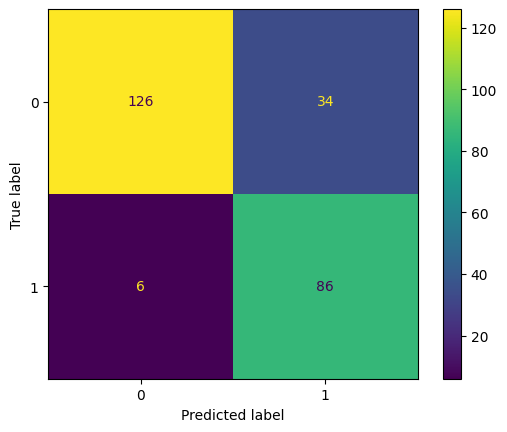

In [60]:
# y_pred with the best recall parameters from GridSearchCV
y_pred_recall = best_model.predict(X_test)

recall_gs = recall_score(y_test, y_pred_recall)
cm = confusion_matrix(y_test, y_pred_recall, labels = models[0].classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = models[0].classes_)
disp.plot()
plt.show()


In [61]:
y_pred = models[0].predict(X_test)
prev_accuracy = recall_score(y_test, y_pred)
print(f"Previous recall of LogisticRegression is {prev_accuracy}")

if recall_gs > prev_accuracy:
    print("Recall improved after GridSearch")
    print(f'Random Search recall is {recall_gs}')
else: 
    print("Recall did not improve after Random Search")

Previous recall of LogisticRegression is 0.9239130434782609
Recall improved after GridSearch
Random Search recall is 0.9347826086956522


## RandomSearch for Logistic Regression, recall

In [62]:
#Randomsearch for logistic regression

param_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C': np.logspace(-4, 4, 20),
    'solver' : ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga']
    }
]

randomized_search = RandomizedSearchCV(estimator = models[0],
                           param_distributions = param_grid,
                           scoring = 'recall',
                           cv = kf_10).fit(X_train, y_train)

# Get the best estimator
best_model_rs = randomized_search.best_estimator_

print(f"Best parameters: {randomized_search.best_params_}")
print(f"Best cross-validation score: {randomized_search.best_score_}")

Best parameters: {'solver': 'saga', 'penalty': 'l1', 'C': np.float64(10000.0)}
Best cross-validation score: 0.8807692307692309


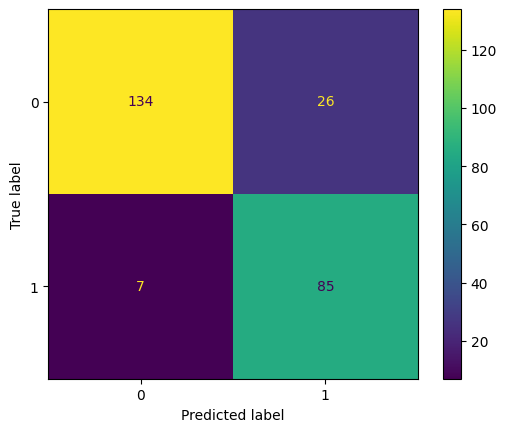

In [63]:
#now use best parameters from random search to predict y_pred

y_pred_recall_rs = best_model_rs.predict(X_test)

recall_rs = accuracy_score(y_test, y_pred_recall_rs)
cm_rs = confusion_matrix(y_test, y_pred_recall_rs, labels = models[0].classes_) 
disp = ConfusionMatrixDisplay(confusion_matrix = cm_rs, display_labels = models[0].classes_)
disp.plot()
plt.show()

In [64]:
y_pred = models[0].predict(X_test)
prev_accuracy = accuracy_score(y_test, y_pred)
print(f"Previous recall of LogisticRegression is {prev_accuracy}")

if recall_rs > prev_accuracy:
    print("Recall improved after Random Search")
    print(f'Random Search recall is {recall_rs}')
else: 
    print("Recall did not improve after Random Search")

Previous recall of LogisticRegression is 0.8690476190476191
Recall did not improve after Random Search


# AdaBoost

## GridSearch for AdaBoost, recall

In [65]:

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.5, 1.0],
    'algorithm': ['SAMME', 'SAMME.R']
}

grid_search = GridSearchCV(estimator = models[3],
                           param_grid = param_grid,
                           scoring = 'recall',
                           cv = kf_10).fit(X_train, y_train)

# Get the best estimator
best_model = grid_search.best_estimator_

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")

Best parameters: {'algorithm': 'SAMME', 'learning_rate': 0.1, 'n_estimators': 50}
Best cross-validation score: 0.9346153846153846


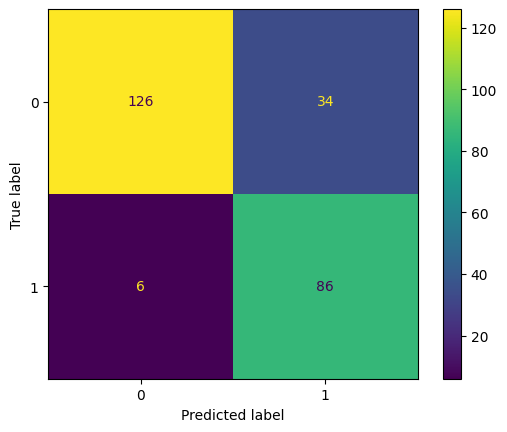

In [66]:
# y_pred with the best recall parameters from GridSearchCV
y_pred_recall = best_model.predict(X_test)

recall_gs = recall_score(y_test, y_pred_recall)
cm = confusion_matrix(y_test, y_pred_recall, labels = models[3].classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = models[3].classes_)
disp.plot()
plt.show()


In [69]:
y_pred = models[3].predict(X_test)
prev_accuracy = recall_score(y_test, y_pred)
print(f"Previous recall of {models[3]} is {prev_accuracy}")

if recall_gs > prev_accuracy:
    print("Recall improved after GridSearch")
    print(f'Random Search recall is {recall_gs}')
else: 
    print("Recall did not improve after Grid Search")

Previous recall of AdaBoostClassifier() is 0.9347826086956522
Recall did not improve after Grid Search


## RandomSearch for AdaBoost, recall

In [71]:
# RandomSearch for SVM

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.5, 1.0],
    'algorithm': ['SAMME', 'SAMME.R']
}

random_search = RandomizedSearchCV(estimator = models[3],
                           param_distributions = param_grid,
                           scoring = 'recall',
                           cv = kf_10).fit(X_train, y_train)

# Get the best estimator
best_model = random_search.best_estimator_

print(f"Best parameters: {random_search.best_params_}")
print(f"Best cross-validation score: {random_search.best_score_}")

Best parameters: {'n_estimators': 50, 'learning_rate': 0.1, 'algorithm': 'SAMME'}
Best cross-validation score: 0.9346153846153846


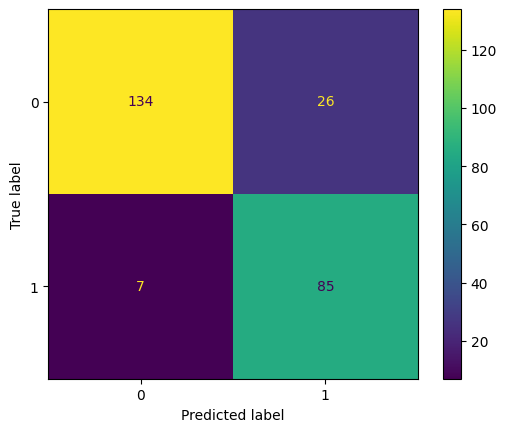

In [72]:
#now use best parameters from random search to predict y_pred

y_pred_recall_rs = best_model_rs.predict(X_test)


recall_rs = recall_score(y_test, y_pred_recall_rs)
cm_rs = confusion_matrix(y_test, y_pred_recall_rs, labels = models[3].classes_) 
disp = ConfusionMatrixDisplay(confusion_matrix = cm_rs, display_labels = models[3].classes_)
disp.plot()
plt.show()

In [73]:
y_pred = models[3].predict(X_test)
prev_recall = recall_score(y_test, y_pred)
print(f"Previous recall of {models[3]} is {prev_accuracy}")

if recall_rs > prev_recall:
    print("Recall improved after Random Search")
    print(f'Random Search accuracy is {recall_rs}')
else: 
    print("Recall did not improve after Random Search")

Previous recall of AdaBoostClassifier() is 0.9347826086956522
Recall did not improve after Random Search
